# Download the Data

In [1]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [14]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from matplotlib import pyplot as plt


!rm -rf 'dataset' TRAIN TEST VAL TRAIN_LST TEST_LST VAL_LST 
!mkdir 'dataset' TRAIN TEST VAL TRAIN_LST TEST_LST VAL_LST 

s3 = boto3.client('s3')
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = 'classification-train-data-0009-6572-9629'
prefix = 'brain-tumor/dataset'
dataset_file = 'brain-mri-images-for-brain-tumor-detection.zip'
IMG_PATH = './dataset/'
TRAIN_DIR = 'TRAIN/'
TRAIN_LST_DIR = 'TRAIN_LST/'
TEST_DIR = 'TEST/'
TEST_LST_DIR = 'TEST_LST/'
VAL_DIR = 'VAL/'
VAL_LST_DIR = 'VAL_LST/'
IMG_SIZE = (224,224)

s3.download_file(bucket, os.path.join(prefix, dataset_file), os.path.join('dataset', dataset_file))
!unzip 'dataset/brain-mri-images-for-brain-tumor-detection.zip' -d 'dataset/'
!rm 'dataset/brain-mri-images-for-brain-tumor-detection.zip'
!mv 'dataset/brain_tumor_dataset/yes' 'dataset/yes'
!mv 'dataset/brain_tumor_dataset/no' 'dataset/no'
!rm -rf 'dataset/brain_tumor_dataset'

Archive:  dataset/brain-mri-images-for-brain-tumor-detection.zip
   creating: dataset/brain_tumor_dataset/
   creating: dataset/brain_tumor_dataset/no/
  inflating: dataset/brain_tumor_dataset/no/30 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/22 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/41 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/no 10.jpg  
  inflating: dataset/brain_tumor_dataset/no/18 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/no 9.png  
  inflating: dataset/brain_tumor_dataset/no/no 7.jpeg  
  inflating: dataset/brain_tumor_dataset/no/no 8.jpg  
  inflating: dataset/brain_tumor_dataset/no/no.jpg  
  inflating: dataset/brain_tumor_dataset/no/3 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/43 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/20 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/32 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/2 no.jpeg  
  inflating: d

  inflating: dataset/brain_tumor_dataset/yes/Y108.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y120.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y242.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y256.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y18.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y24.jpg  
 extracting: dataset/brain_tumor_dataset/yes/Y30.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y31.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y25.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y19.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y257.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y243.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y109.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y255.JPG  
  inflating: dataset/brain_tumor_dataset/yes/Y33.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y27.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y26.jpg  
  inflating: dataset/brain_tumor_dataset/yes/Y32.jpg  
  

In [39]:
def rename(img_path):
    i = 1
    for sf in os.scandir(img_path):
        if(sf.is_dir()):
            class_name = sf.name
            for file in os.listdir(os.path.join(IMG_PATH, class_name)):
                new_name = os.path.join(os.path.join(IMG_PATH, class_name),'{}_{}.jpg'.format(i, class_name))
                os.rename(os.path.join(os.path.join(IMG_PATH, class_name), file), 
                          new_name)
                i = i + 1

def split(img_path, train_dir, test_dir, val_dir):
    # split the data by train/val/test
    for CLASS in os.listdir(img_path):
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(img_path + CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(img_path + CLASS)):
                img = img_path + CLASS + '/' + FILE_NAME
                if n < 2:
                    shutil.copy(img, os.path.join(test_dir, FILE_NAME))
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, os.path.join(train_dir, FILE_NAME))
                else:
                    shutil.copy(img, os.path.join(val_dir, FILE_NAME))

def build_ann(img_path, annotation_path):
    annotations = {}
    f = open(os.path.join(annotation_path, 'annotations.lst'), 'w')
    for file in os.listdir(os.path.join(img_path)):
        arr = file.split('_')
        class_name = arr[1].split('.')[0]
        class_id = 0
        if(class_name == 'yes'):
            class_id = 1
        str = '{}\t{}\t{}\n'.format(arr[0], class_id, file)
        f.write(str)
    f.close()


def get_annotations(file_path):
    annotations = {}
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()
    for i, row in enumerate(rows):
        _, class_name, image_name = row.split('\t')
        annotations[image_name] = class_name
    return annotations

In [40]:
rename(IMG_PATH)


split(IMG_PATH, TRAIN_DIR, TEST_DIR, VAL_DIR)

build_ann(TRAIN_DIR, TRAIN_LST_DIR)
build_ann(TEST_DIR, TEST_LST_DIR)
build_ann(VAL_DIR, VAL_LST_DIR)

In [43]:
train_annotations = get_annotations(TRAIN_LST_DIR + '/annotations.lst')
val_annotations = get_annotations(VAL_LST_DIR + '/annotations.lst')

In [44]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in val_annotations.items():
    all_annotations[key] = value

In [45]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [46]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

256
78


# Visualize Data

In [47]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['0', '1']

Num of classes: 2


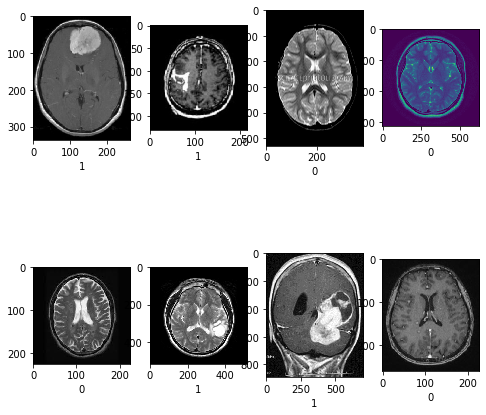

In [49]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('TRAIN/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [50]:

training_image = get_image_uri(boto3.Session().region_name, 'image-classification', repo_version='latest')

print(training_image)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


469771592824.dkr.ecr.ca-central-1.amazonaws.com/image-classification:latest


# Uploading Data to S3

In [52]:
%%time

s3_train_path = sagemaker_session.upload_data(path='TRAIN' , bucket=bucket, 
                                              key_prefix='train')
s3_train_lst_path = sagemaker_session.upload_data(path='TRAIN_LST' , bucket=bucket, 
                                                  key_prefix='train_lst')
s3_validation_path = sagemaker_session.upload_data(path='VAL' , bucket=bucket, 
                                                   key_prefix='validation')
s3_validation_lst_path = sagemaker_session.upload_data(path='VAL_LST' , bucket=bucket, 
                                                       key_prefix='validation_lst')


CPU times: user 1.67 s, sys: 85.5 ms, total: 1.76 s
Wall time: 14.3 s


# SageMaker Estimator

In [53]:
train_instance_type='ml.p3.2xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m4.xlarge'     # The type of EC2 instance which will be used for deployment

model = sagemaker.estimator.Estimator(
    training_image,            # Your entry script
    role=role,
    train_instance_count=1,                   # "The number of GPUs instances to use"
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=900,
    input_mode='File',
    output_path='s3://{}/output'.format(bucket)
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [54]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    num_classes=2,
    image_shape='3,224,224',
    mini_batch_size=32,
    resize=224,
    epochs = 10,
    learning_rate=0.001,
    num_training_samples=train_count,
    augmentation_type='crop_color_transform'
)

# Data Channels

In [55]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')
train_lst_data = sagemaker.session.s3_input(s3_train_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.session.s3_input(s3_validation_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [56]:
data_channels= {
    'train': train_data,
    'train_lst': train_lst_data,
    'validation': validation_data,
    'validation_lst': validation_lst_data
}

# Model Training

In [ ]:
model.fit(inputs=data_channels, logs=True)

2020-10-09 19:10:29 Starting - Starting the training job......

# Deploy Model

In [26]:
deployed_model = model.deploy(initial_instance_count=1, instance_type=deploy_instance_type)
print('\n model deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!
 model deployed!


# Predictions

In [27]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1428


In [30]:
deployed_model.content_type = 'image/jpeg'

In [41]:
index = 2
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)
print(results)

[2.7598278506957286e-07, 3.7659543750123703e-07, 1.3311209841049276e-05, 1.75678735558904e-06, 6.5849535531015135e-06, 0.00011158591223647818, 5.432944476524426e-07, 1.1148235898872372e-05, 0.001692850375548005, 6.036294053046731e-06, 4.356582394393627e-06, 0.0005322646466083825, 1.940270948352918e-07, 2.861972063783469e-07, 0.00014059888781048357, 1.1290738939351286e-06, 7.2027860369416885e-06, 1.176167870653444e-06, 3.9381782698910683e-05, 7.659932244052925e-09, 1.8483490293874638e-06, 1.2952507688623882e-07, 0.00018743309192359447, 0.00015903009625617415, 6.065926754672546e-06, 4.468792394618504e-05, 0.0015143804484978318, 0.9950369000434875, 2.3371883628442447e-07, 0.00022385019110515714, 7.367848411377054e-07, 2.6484556769901246e-08, 9.098065589796533e-08, 2.8343661142571364e-06, 1.2705122571787797e-05, 0.00021587556693702936, 2.209355625382159e-05]


In [42]:
classes[np.argmax(results)]

'saint_bernard'

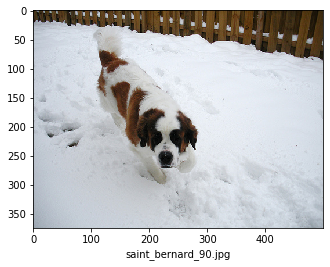

In [43]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)